In [64]:
from cde_utility import *
import matplotlib.colors as colors
from numba import jit

## Dynamical Response

In [65]:
hbar = 6.626*10**(-34)/twopi
ev = 1.6*10**(-19)
c0 = 2.99792458*10**8
nm = 10**(-9)
d0 = 75*nm
a_o_d = 1.0/3.0
a0 = d0*a_o_d
# print(hbar, ev, c0, nm)

def ev2kw( w, d ):
    return w*ev/hbar/c0/(twopi/d)

def kw2ev( kw, d ):
    return kw*twopi/d*c0*hbar/ev

# ev2kw(4.0, 75*nm)
# kw2ev( 0.25, 100*nm )

def eps_drude(w):
    w_pl = 11.34
    eps_a, eps_b, gamma = 5.45, 6.18, 0.05
    return eps_a - ( eps_b - eps_a )*w_pl**2 / w / (w + 1j*gamma)

def alpha(kw, eps_func, a=25*nm, a_o_d=1.0/3.0, unit='twopi/d', rad_corr=True):
    eps = eps_func(kw)
    if unit == 'twopi/d':
        d = a / a_o_d
        w = kw2ev(kw, d)
    elif unit == 'eV':
        w = kw*ev/hbar
    else:
        raise ValueError(r"Unit input is '{}'. ".format(unit)+\
                         r"Unit for kw must be 'twopi/d' or 'eV'!")
    pol = ( eps - 1.0 ) / ( eps + 2.0 ) * a**3
    if rad_corr:
        pol_inv = 1.0/pol - 1j*2.0/3.0*( w/c0 )**3
        pol = 1.0 / pol_inv
    return pol

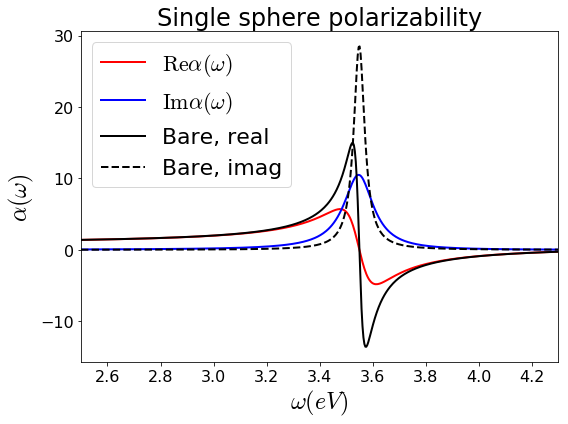

In [66]:
ws = np.linspace(2.5, 4.3, 501)
# epsw = eps_drude(ws)
# epsw = (epsw - 1)/(epsw+2)
# epsr = np.real(epsw)
# epsi = np.imag(epsw)
pol = alpha(ws, eps_drude, unit='eV', rad_corr=True)/a0**3
polr, poli = pol.real, pol.imag
pol_no_cor = alpha(ws, eps_drude, unit='eV', rad_corr=False)/a0**3
pol_no_r, pol_no_i = pol_no_cor.real, pol_no_cor.imag

plt.figure(figsize=(8,6))
# plt.plot(ws, epsr, 'ro-', label='$\mathrm{Re}\epsilon(\omega)$')
# plt.plot(ws, epsi, 'bo-', label='$\mathrm{Im}\epsilon(\omega)$')
plt.plot(ws, polr, 'r-', label=r'$\mathrm{Re}\alpha(\omega)$')
plt.plot(ws, poli, 'b-', label=r'$\mathrm{Im}\alpha(\omega)$')
axes = plt.gca()
ymin, ymax = axes.get_ylim()
# plt.vlines(3.57, ymin, ymax, color='k', linestyles='dashed')
plt.plot(ws, pol_no_r, 'k-', label='Bare, real')
plt.plot(ws, pol_no_i, 'k--', label='Bare, imag')
plt.xlabel(r'$\omega(eV)$')
plt.ylabel(r'$\alpha(\omega)$')
plt.title('Single sphere polarizability')
plt.legend(loc='best', fontsize=22)
plt.xlim(ws[0], ws[-1])
# plt.ylim(ymin, ymax)
plt.tight_layout()
plt.savefig('single-sphere-pol.pdf')
plt.show()

In [67]:
max_freq = np.argmax(poli)
print(ws[max_freq], poli[max_freq])
max_freq_no_cor = np.argmax(pol_no_i)
print(ws[max_freq_no_cor], pol_no_i[max_freq_no_cor])

3.5476 10.49878883362858
3.5511999999999997 28.479426510741117


### T-mode
$$
\beta_z = k_{\omega}^2 S_1 + ik_{\omega} S_2 - S_3
$$
where
$$
S_{\alpha} = 
\sum_{\vec{R}\neq \vec{0}} e^{i\vec{k}\cdot\vec{R}}
\frac{e^{i k_{\omega} R}}{R^{\alpha}}
\quad \alpha=1, 2, 3
$$

In [68]:
# @jit(nopython=True)
def beta_z( kvec, kw, N_2, N_3, N_G, N_R, E, lat ):
    '''
    Fully dynamical lattice sum z-component.
    ------
    Input:
    ------
    kvec: k-vector length 3 1-D list/array. Unit twopi/d, d=1.0
    kw: omega/c in reduced unit 1/d, d=1.0
    N_z: real-space lattice truncation in direct summation 
    for 1/R^2 and 1/R^3.
    N_G: reciprocal-space trunctation for Ewald method.
    N_R: real-space truncation for Ewald method.
    E: Ewald parameter for 1/R summation. Usually E=\sqrt(\pi)/d.
    lat: lattice object.
    -------
    Output:
    -------
    z-component of lattice sum of dyadic Green's function at (kvec, kw).
    Unit: 1/d^3
    '''
    s1 = S_ewald(kvec, kw, N_G, N_R, E, lat, 1, 1, 1)
    s2 = Rsum_direct(fR2, N_2, r0, kvec, kw, lat)
    s3 = Rsum_direct(fR3, N_3, r0, kvec, kw, lat)
    beta_z = kw**2*s1 + 1j*kw*s2 - s3
    return beta_z

#### Dynamical response at fix k-point

CPU times: user 6.81 s, sys: 12.3 s, total: 19.1 s
Wall time: 2.44 s
CPU times: user 6.87 s, sys: 12.4 s, total: 19.3 s
Wall time: 2.46 s
Single sphere resonant frequency(eV): 3.5476
Inside-light-cone mode resonant frequency(eV): 3.8032
Outside-light-cone mode resonant frequency(eV): 3.5296


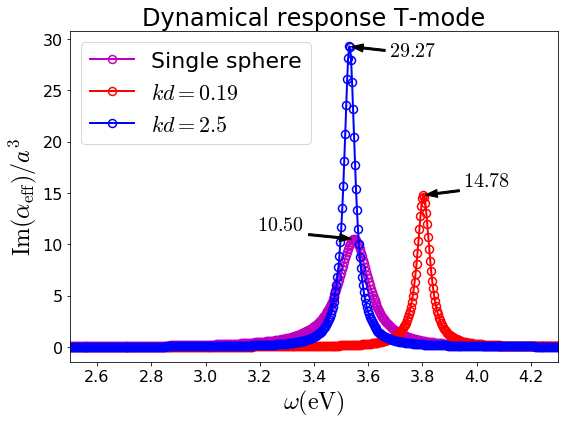

In [69]:
lat = square
d = 75*nm
a_o_d = 1.0/3.0
a = d*a_o_d

# Frequency range
nw = 501
w_min, w_max = 2.5, 4.3
ws = np.linspace(w_min, w_max, nw)
kws = ev2kw(ws, d)*twopi

# Lattice sum parameters
N_2 = 50
N_3 = 25
r0 = [0, 0, 0]
E = 1*np.sqrt(np.pi/vec_norm(lat.a1)/vec_norm(lat.a2))
N_G = 5
N_R = 5

# Polarizability
pol = alpha(ws, eps_drude, a=a, a_o_d=a_o_d, 
            unit='eV', rad_corr=True)

kvec_in = [0.19, 0, 0]
kvec_out = [2.5, 0, 0]
%time beta_z_in = np.array( [ beta_z( kvec_in, kw, N_2, N_3, N_G, N_R, E, lat ) \
                             for kw in kws ] )
Mz_in = 1.0/pol - beta_z_in/d**3

%time beta_z_out = np.array( [ beta_z( kvec_out, kw, N_2, N_3, N_G, N_R, E, lat ) \
                             for kw in kws ] )
Mz_out = 1.0/pol - beta_z_out/d**3

# Resonant frequency of single sphere, in-side light-cone mode
# and out-side light-cone mode
peak_0 = np.argmax(np.imag(pol))
w0, y0 = ws[peak_0], np.imag(pol[peak_0])/a**3
peak_in = np.argmax(np.imag(1.0/Mz_in))
w0_in, y_in = ws[peak_in], np.imag(1.0/Mz_in[peak_in])/a**3
peak_out = np.argmax(np.imag(1.0/Mz_out))
w0_out, y_out = ws[peak_out], np.imag(1.0/Mz_out[peak_out])/a**3
w0_all = w0, w0_in, w0_out
print('Single sphere resonant frequency(eV): {:.4f}'.format(w0))
print('Inside-light-cone mode resonant frequency(eV): {:.4f}'.format(w0_in))
print('Outside-light-cone mode resonant frequency(eV): {:.4f}'.format(w0_out))

# Plot
marker_style = dict(linestyle='-', marker='o', \
                    markersize=8, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, clip_on=True)

plt.figure(figsize=(8,6))
plt.plot(ws, np.imag(pol)/a**3, 'm-', 
         **marker_style, label='Single sphere')
plt.plot(ws, np.imag(1.0/Mz_in)/a**3, 'r-', 
         **marker_style, label=r'$kd=0.19$')
plt.plot(ws, np.imag(1.0/Mz_out)/a**3, 'b-', 
         **marker_style, label=r'$kd=2.5$')
axes = plt.gca()
ymin, ymax = axes.get_ylim()
# for w in w0_all:
#     plt.vlines(w, ymin, ymax, color='gray', linestyles='dashed', lw=2.0)
myarrow = dict(facecolor='black', width=2, headwidth=8, shrink=0.05)
plt.annotate('${:.2f}$'.format(y0), 
             xy=(w0,y0), xycoords='data',
             xytext=(-50,5), textcoords='offset points',
             arrowprops=myarrow,
             horizontalalignment='right', verticalalignment='bottom',
             fontsize=20)
plt.annotate('${:.2f}$'.format(y_in), 
             xy=(w0_in,y_in), xycoords='data',
             xytext=(40,5), textcoords='offset points',
             arrowprops=myarrow,
             horizontalalignment='left', verticalalignment='bottom',
             fontsize=20)
plt.annotate('${:.2f}$'.format(y_out), 
             xy=(w0_out,y_out), xycoords='data',
             xytext=(40,5), textcoords='offset points',
             arrowprops=myarrow,
             horizontalalignment='left', verticalalignment='top',
             fontsize=20)
plt.xlim(ws[0], ws[-1])
plt.ylim(ymin, ymax)
plt.xlabel(r'$\omega(\mathrm{eV})$')
plt.ylabel(r'$\mathrm{Im}(\alpha_{\mathrm{eff}})/a^3$')
plt.legend(loc='best', fontsize=22)
plt.title('Dynamical response T-mode')
plt.tight_layout()
plt.savefig('T-mode-in-out-lightcone.pdf')
plt.show()

#### $\Gamma-X$ dispersion

In [164]:
lat = square
Gamma = lat.reci_vec(0, 0, 0)
X = lat.reci_vec(0.5, 0, 0)
d = 75*nm
a_o_d = 1.0/3.0
a = d*a_o_d
nk = 101
nw = 101
w_min, w_max = 2.5, 4.3
ws = np.linspace(w_min, w_max, nw)
kws = ev2kw(ws, d)*twopi

kmesh = kpath(Gamma, X, nk, end_point=True)
ks = np.array(kmesh)[:, 0]/twopi
kgrid, wgrid = np.meshgrid( ks, ws )

N_2, N_3 = 50, 25
r0 = [0, 0, 0]
E = 1*np.sqrt(np.pi/vec_norm(lat.a1)/vec_norm(lat.a2))
N_G = 5
N_R = 5
pols = alpha(ws, eps_drude, a=a, a_o_d=a_o_d, 
             unit='eV', rad_corr=True)
%time beta_zz = np.array( [ [ beta_z( kvec, kw, N_2, N_3, N_G, N_R, E, lat ) \
                             for kw in kws ] for kvec in kmesh] )

Mz = 1.0/pols - beta_zz/d**3

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
alpha_eff = 1.0 / Mz / a**3
Z = np.imag(alpha_eff.T)
im = ax.pcolormesh(kgrid, wgrid, Z, 
                   vmin = 0, vmax = 35,
                   cmap='RdBu_r', shading='gouraud')
fig.colorbar(im)
plt.xlabel(r'$k(2\pi/d)$')
plt.ylabel(r'$\omega(\mathrm{eV})$')
plt.tight_layout()
plt.savefig('T-mode-dynamical.pdf')
plt.show()

### In-plane Mode
$\newcommand{\vR}{\vec{R}}$
$\newcommand{\vkb}{\vec{k}_B}$
$\newcommand{\vnull}{\vec{0}}$
$\newcommand{\kw}{k_{\omega}}$
$$
\beta_{ii} = 3 S_3^{ii} - 3 i\kw S_2^{ii} - \kw^2 S_1^{ii} + \beta_z, \\
\beta_{ij} = 3 S_3^{ij} - 3 i\kw S_2^{ij} - \kw^2 S_1^{ij}
$$
$$
S_{\alpha}^{ij} = 
\sum_{\vR\neq\vnull} e^{i\vkb\cdot\vR} e^{i\kw R} \frac{ R_i R_j}{ R^{\alpha+2} }, 
\quad \alpha=1, 2, 3, \ldots
$$

#### $S_1^{ij}$
$$
S_{1}^{ij} = 
\sum_{\vR\neq\vnull} e^{i\vkb\cdot\vR} e^{i\kw R} \frac{ R_i R_j}{ R^{3} }
=-\frac{\partial^2 S_{3}}{\partial k_i \partial k_j}
$$

In [71]:
# Finite-difference of lattice sum with respect to k-vector
def diff2_S_k(kvec, kw, uv1, uv2, dk, lat, N_R, sum_func):
    r0 = [0, 0, 0]
    kvec = np.array(kvec)
    uv1 = np.array(uv1)
    uv2 = np.array(uv2)
    
    k11 = kvec - dk/2.0*uv1 + dk/2.0*uv2
    k12 = kvec + dk/2.0*uv1 + dk/2.0*uv2
    k21 = kvec - dk/2.0*uv1 - dk/2.0*uv2
    k22 = kvec + dk/2.0*uv1 - dk/2.0*uv2
    
    s11 = Rsum_direct(sum_func, N_R, r0, k11, kw, lat)
    s12 = Rsum_direct(sum_func, N_R, r0, k12, kw, lat)
    s21 = Rsum_direct(sum_func, N_R, r0, k21, kw, lat)
    s22 = Rsum_direct(sum_func, N_R, r0, k22, kw, lat)
#     print(s11, s12, s21, s22)
    return ( -s11 + s12 + s21 - s22 ) / dk**2

In [129]:
# Test diff2_S_k to find optimal division
lat = square
dk = 1e-5
kvec = [2.5, 0, 0]
ux = lat.a1
uy = lat.a2
uv1 = ux
uv2 = ux
kw = 0.25*twopi
N_R = 200
N_direct = 5000
fR3 = lambda Rvec: fRn(Rvec, 3)
fR1xx = lambda Rvec: fnRij(Rvec, 1, 0, 0)

%time s1xx = -diff2_S_k(kvec, kw, uv1, uv2, dk, lat, N_R, fR3)
%time s1xx_direct = Rsum_direct(fR1xx, N_direct, r0, kvec, kw, lat)

print('S_1 xx by direct summation: {:.6f}'\
      .format(s1xx_direct))
print('S_1 xx by finite-difference: {:.6f}'\
      .format(s1xx))
print('Real-part error: {:.2e}'.format( np.real(s1xx-s1xx_direct)) )
print('Imaginary-part error: {:.2e}'.format( np.imag(s1xx-s1xx_direct)) )

CPU times: user 572 ms, sys: 1.07 s, total: 1.64 s
Wall time: 217 ms
CPU times: user 28.1 s, sys: 7.28 s, total: 35.4 s
Wall time: 33.5 s
S_1 xx by direct summation: -0.378242-2.804916j
S_1 xx by finite-difference: -0.399097-2.999607j
Real-part error: -2.09e-02
Imaginary-part error: -1.95e-01


In [134]:
# Test the impact of finite-difference division
N_R = 200
dks = np.power( 10.0, -np.arange(2,8) )
%time s1xxs = [ -diff2_S_k(kvec, kw, uv1, uv2, dk, lat, N_R, fR3) \
               for dk in dks ]
for dk, s in zip( dks, s1xxs ):
#     print('Real-part error: {:.2e}'.format( np.real(s-s1xx_direct)) )
#     print('Imaginary-part error: {:.2e}'.format( np.imag(s-s1xx_direct)) )
    print('{:.2e} {:.2e} {:.2e}'\
          .format( dk, np.real(s-s1xx_direct), np.imag(s-s1xx_direct) ))

CPU times: user 3.8 s, sys: 6.26 s, total: 10.1 s
Wall time: 1.33 s
1.00e-02 -1.73e-02 -1.27e-01
1.00e-03 -2.08e-02 -1.94e-01
1.00e-04 -2.08e-02 -1.95e-01
1.00e-05 -2.09e-02 -1.95e-01
1.00e-06 -2.19e-02 -1.95e-01
1.00e-07 -1.27e-01 -1.70e-01


####  $\beta_{ij}$

In [121]:
# fR3yx = lambda Rvec: fnRij(Rvec, 3, 1, 0)
# fR3xx = lambda Rvec: fnRij(Rvec, 3, 0, 0)
# fR3yy = lambda Rvec: fnRij(Rvec, 3, 1, 1)

def beta_ij( i, j, kvec, kw, dk, N_1_direct, \
            N_2_direct, N_3_direct, \
            N_G, N_R, E, lat ):
    fR3 = lambda Rvec: fRn(Rvec, 3)
    fR2ij = lambda Rvec: fnRij(Rvec, 2, i, j)
    fR3ij = lambda Rvec: fnRij(Rvec, 3, i, j)
    r0 = [0, 0, 0]
#     s1 = S_ewald(kvec, kw, N_G, N_R, E, lat, 1, 1, 1) # s1_ij need to be solved!
    uv1 = lat.lat_basis[i]
    uv2 = lat.lat_basis[j]
    s1 = -diff2_S_k(kvec, kw, uv1, uv2, dk, lat, N_1_direct, fR3)
    s2 = Rsum_direct(fR2ij, N_2_direct, r0, kvec, kw, lat)
    s3 = Rsum_direct(fR3ij, N_3_direct, r0, kvec, kw, lat)
    beta = 3*s3 - 3*1j*kw*s2 - kw**2*s1
    if i == j:
        beta_zz = beta_z( kvec, kw, N_2_direct, N_3_direct, \
                         N_G, N_R, E, lat )
        beta = beta + beta_zz
    return beta

def beta_matrix( kvec, kw, dk, N_1_direct, N_2_direct, N_3_direct, \
                N_G, N_R, E, lat ):
    m11 = beta_ij( 0, 0, kvec, kw, dk, N_1_direct, \
                  N_2_direct, N_3_direct, N_G, N_R, E, lat)
    m12 = beta_ij( 0, 1, kvec, kw, dk, N_1_direct, \
                  N_2_direct, N_3_direct, N_G, N_R, E, lat)
    m21 = m12
    m22 = beta_ij( 1, 1, kvec, kw, dk, N_1_direct, \
                  N_2_direct, N_3_direct, N_G, N_R, E, lat)
    return np.array( [ [ m11, m12 ], [ m21, m22 ] ] )

CPU times: user 7min 7s, sys: 12min 33s, total: 19min 41s
Wall time: 2min 31s


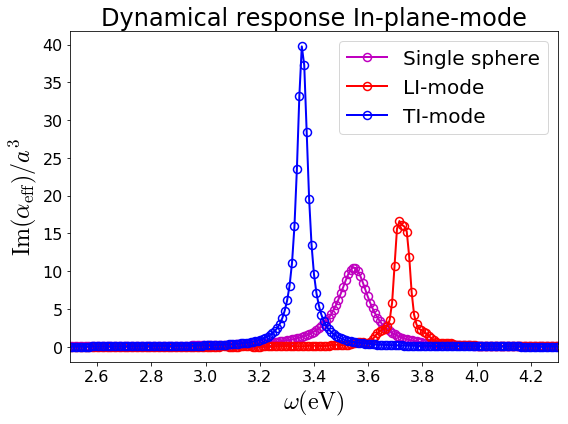

In [136]:
lat = square
kvec = [2.5, 0, 0]
nw = 201
w_min, w_max = 2.5, 4.3
ws = np.linspace(w_min, w_max, nw)
kws = ev2kw(ws, d)*twopi

dk = 1e-2
N_1_direct = 200
N_2_direct = 100
N_3_direct = 50
N_G, N_R = 5, 5
E = 1*np.sqrt(np.pi/vec_norm(lat.a1)/vec_norm(lat.a2))

d = 75*nm
a_o_d = 1.0/3.0
a = d*a_o_d
pols = alpha(ws, eps_drude, a=a, a_o_d=a_o_d, \
             unit='eV', rad_corr=True)

%time beta = [ beta_matrix( kvec, kw, dk, N_1_direct, \
                           N_2_direct, N_3_direct, \
                           N_G, N_R, E, lat ) \
              for kw in kws ]
m_eig_1, m_eig_2 = np.linalg.eigvals( beta ).T

w1 = 1.0/( 1.0/pols - m_eig_1/d**3 )/a**3
w2 = 1.0/( 1.0/pols - m_eig_2/d**3 )/a**3

# Plot
marker_style = dict(linestyle='-', marker='o', \
                    markersize=8, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, clip_on=True)

plt.figure(figsize=(8,6))
plt.plot(ws, np.imag(pols)/a**3, 'm-', \
         **marker_style, label='Single sphere')
plt.plot(ws, np.imag(w1), 'ro-', \
         **marker_style, label=r'LI-mode')
plt.plot(ws, np.imag(w2), 'bo-', \
         **marker_style, label=r'TI-mode')
plt.xlim(ws[0], ws[-1])
plt.xlabel(r'$\omega(\mathrm{eV})$')
plt.ylabel(r'$\mathrm{Im}(\alpha_{\mathrm{eff}})/a^3$')
plt.legend(loc='best', fontsize=20)
plt.title('Dynamical response In-plane-mode')
plt.tight_layout()
plt.savefig('Inplane-mode-outside-light-cone.pdf')
plt.show()

In [137]:
peak1 = np.argmax(np.imag(w1))
peak2 = np.argmax(np.imag(w2))
print(ws[peak1], np.imag(w1[peak1]) )
print(ws[peak2], np.imag(w2[peak2]) )

3.715 16.643696892465865
3.355 39.749483318412324


### $\Gamma-X$ dispersion

In [162]:
lat = square
Gamma = lat.reci_vec(0, 0, 0)
X = lat.reci_vec(0.5, 0, 0)
d = 75*nm
a_o_d = 1.0/3.0
a = d*a_o_d
nk = 51
nw = 51
w_min, w_max = 2.5, 4.3
ws = np.linspace(w_min, w_max, nw)
kws = ev2kw(ws, d)*twopi

kmesh = kpath(Gamma, X, nk, end_point=True)
ks = np.array(kmesh)[:, 0]/twopi
# ks = np.arange(nk)
kgrid, wgrid = np.meshgrid( ks, ws )

In [138]:
N_2, N_3 = 100, 50
r0 = [0, 0, 0]
dk = 1e-2
N_1_direct = 50
N_2_direct = 100
N_3_direct = 50
E = 1*np.sqrt(np.pi/vec_norm(lat.a1)/vec_norm(lat.a2))
N_G = 5
N_R = 5

pols = alpha(ws, eps_drude, a=a, a_o_d=a_o_d, 
             unit='eV', rad_corr=True)
%time beta = [ [ beta_matrix( kvec, kw, dk, N_1_direct, \
                             N_2_direct, N_3_direct, \
                             N_G, N_R, E, lat ) \
                for kw in kws] for kvec in kmesh ]

m_eig_1, m_eig_2 = np.linalg.eigvals( beta ).T

w1 = 1.0/( 1.0/pols - m_eig_1/d**3 )/a**3
w2 = 1.0/( 1.0/pols - m_eig_2/d**3 )/a**3

CPU times: user 17min 56s, sys: 31min 56s, total: 49min 53s
Wall time: 6min 23s


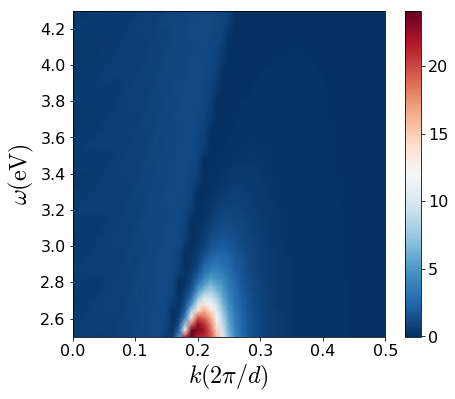

In [163]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
# im1 = ax.pcolormesh(kgrid, wgrid, np.imag(w1), 
# # #                    vmin = 0, vmax = 35,
#                     cmap='RdBu_r')#, shading='gouraud')
# fig.colorbar(im1)
im2 = ax.pcolormesh(kgrid, wgrid, np.imag(w2), 
#                    vmin = 0, vmax = 15,
                    cmap='RdBu_r', shading='gouraud')
fig.colorbar(im2)
plt.xlabel(r'$k(2\pi/d)$')
plt.ylabel(r'$\omega(\mathrm{eV})$')
# plt.tight_layout()
# plt.savefig('I-mode-dynamical.pdf')
plt.show()

In [158]:
np.arange(0.0, 0.6, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])

CPU times: user 282 ms, sys: 81.5 ms, total: 364 ms
Wall time: 252 ms
CPU times: user 256 ms, sys: 74.4 ms, total: 330 ms
Wall time: 219 ms
CPU times: user 240 ms, sys: 67.5 ms, total: 307 ms
Wall time: 288 ms


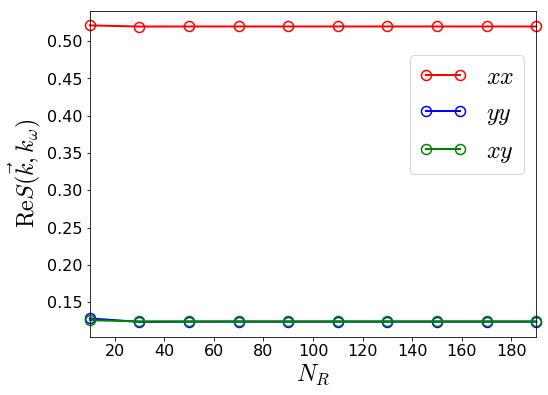

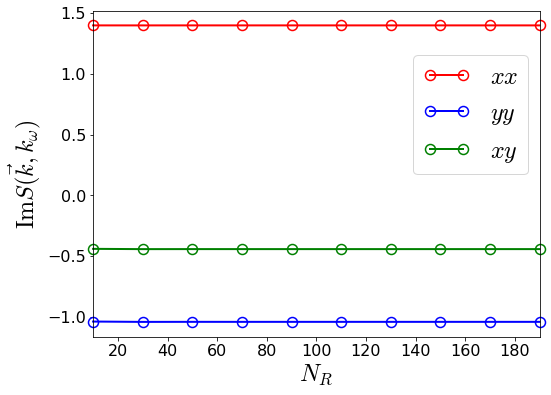

In [23]:
fR1xx = lambda Rvec: fnRij(Rvec, 3, 0, 0)
fR1xy = lambda Rvec: fnRij(Rvec, 3, 0, 1)
fR1yy = lambda Rvec: fnRij(Rvec, 3, 1, 1)
fR3xy = lambda Rvec: fnRij(Rvec, 3, 0, 1)

# Sample calculation for xx, xy, yy  component of 1/R lattice sums
r0 = [0, 0, 0]
kvec = np.array( [0.1, 0.3, 0] )*twopi
w = 3.4
d = 75*nm
kw = ev2kw(w, d)*twopi
lat_test = square
nums = np.arange(10, 200, 20)

%time f1xx = [ Rsum_direct(fR1xx, numR, r0, kvec, kw, lat_test) \
              for numR in nums ]
%time f1xy = [ Rsum_direct(fR1xy, numR, r0, kvec, kw, lat_test) \
              for numR in nums ]
%time f1yy = [ Rsum_direct(fR1yy, numR, r0, kvec, kw, lat_test) \
              for numR in nums ]

marker_style = dict(linestyle='-', marker='o', \
                    markersize=10, markerfacecolor='none', \
                    markerfacecoloralt='gray', markeredgewidth=1.5, \
                    clip_on=False)

plt.figure(figsize=(8,6))
plt.plot(nums, np.real(f1xx), 'ro-', label=r'$xx$', \
        **marker_style)
plt.plot(nums, np.real(f1yy), 'bo-', label=r'$yy$', \
        **marker_style)
plt.plot(nums, np.real(f1xy), 'go-', label=r'$xy$', \
        **marker_style)
plt.xlim((nums[0], nums[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$\mathrm{Re}S(\vec{k}, k_{\omega})$')
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9),\
           numpoints=2, fontsize=24)
# plt.tight_layout()
# plt.savefig('direct-R1ij-sum-real.pdf')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(nums, np.imag(f1xx), 'ro-', label=r'$xx$', \
        **marker_style)
plt.plot(nums, np.imag(f1yy), 'bo-', label=r'$yy$', \
        **marker_style)
plt.plot(nums, np.imag(f1xy), 'go-', label=r'$xy$', \
        **marker_style)
plt.xlim((nums[0], nums[-1]))
plt.xlabel('$N_R$')
plt.ylabel(r'$\mathrm{Im}S(\vec{k}, k_{\omega})$')
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.9),\
           numpoints=2, fontsize=24)
# plt.tight_layout()
# plt.savefig('direct-R1ij-sum-imag.pdf')
plt.show()

In [30]:
N3_xy = 50
%time s3xy1 = Rsum_direct(fR3xy, N3_xy, r0, kvec, kw, lat_test)
N3_xy = 100
%time s3xy2 = Rsum_direct(fR3xy, N3_xy, r0, kvec, kw, lat_test)
print('{:.6f}'.format(s3xy1))
print('{:.6f}'.format(s3xy2))
print('{:.2e}'.format(rel_err(s3xy2.real, s3xy1.real)*s3xy1.real))
print('{:.2e}'.format(rel_err(s3xy2.imag, s3xy1.imag)*s3xy1.imag))

CPU times: user 5.6 ms, sys: 1.87 ms, total: 7.47 ms
Wall time: 4.07 ms
CPU times: user 19.2 ms, sys: 2.67 ms, total: 21.8 ms
Wall time: 12.5 ms
0.124253-0.442612j
0.124285-0.442649j
3.21e-05
3.71e-05
